### Basic principles
    1. simulate the output of a monochromatic incident pulse w/ & w/o shapeError up to HHLM4.
    2. extract the phase information of the output beams w/ & w/o shapeError, to calculate the phase difference needed.
    3. transform the phase difference into a thickness profile, and add phase plate into beamline.
    4. simulate the results w/ & w/o phase plate.
    

In [1]:
from Functions import *
import winsound

In [2]:
FOV1 = 5e-3; N1 = 512
FOV2 = 5e-3; N2 = 10240

# Preliminary

In [3]:
# regular beamline
def define_beamline_normal(
    E0, m1_p=185.0, m1_q=-25.6, m2_p=140.0, m2_q=None,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 0.0,
    hkl2 = [2,2,0], alphaAsym2 = 0.0,
    hkl3 = [5,5,5], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=FOV1, N=N1)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m1_q=m1_q, m2_p=m2_p, m2_q=m2_q)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    im_plate = optics.PPM('im_plate', FOV=FOV2, N=N2,z=HHLM_devices[-1].z+1e-3)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)
    
    im_output = optics.PPM('im_output', FOV=FOV1,N=N1,z=HRM_devices[-1].z+1e-3)

    all_devices = [im_input] + Telescope_devices + HHLM_devices + [im_plate] + HRM_devices + [im_output]
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline

### 1. common simulation parameters

In [4]:
''' Beam parameters '''
N = 1024          # number of sampling points
E0 = 17795        # photon energy [eV]

# parameter dictionary. z_source is in LCLS coordinates (20 meters upstream of undulator exit)
beam_params = {
    'photonEnergy': E0,
    'N': N,
    'sigma_x': 23e-6,
    'sigma_y': 23e-6,
    'rangeFactor': 5,
    'scaleFactor': 10,
    'z_source': 650-26
}

##### common simulation parameters
m1_p = 185.0; m1_q = -25.6
m2_p = 141.4509; m2_p1 = 556.1505
f1 = 10.0; f2 = 10.0            # f1: crystal-mirror distance, f2: mirror focal distance

HHLM_type = '2DCM'              # 2DCM or Zigzag
HHLM_offset=20e-3
pair_distance=200e-3
hkl1 = [1,1,1]; alphaAsym1 = 3.0    # asymmetry angle for the 1st pair of HHLM crystal
hkl2 = [2,2,0]; alphaAsym2 = 0.0    # ````````````````````````2nd pair of HHLM crystal
hkl3 = [5,5,5]; alphaAsym3 = 15.0   # ````````````````````````2nd and 3rd HRM crystal

# list of crystals
crystals = np.array(['HHLM1', 'HHLM2', 'HHLM3', 'HHLM4', 'C1', 'C2']); n_crys = len(crystals)

##### I/O
dir_out = 'output/'; make_dir(dir_out)
dir_ev = dir_out + '{}eV/'.format(E0); make_dir(dir_ev)
dir_case = dir_ev + 'm2_p_optimization/'; make_dir(dir_case)

print('\nCWD:',dir_case)

dir_plot = dir_case+'{}_{}_{}/'.format(HHLM_type, hkl1[0]*100+hkl1[1]*10+hkl1[2],
                                      hkl2[0]*100+hkl2[1]*10+hkl2[2]); make_dir(dir_plot)
dir_plot += '{}_{}_deg_{}mm_offset/'.format(alphaAsym1, alphaAsym2, 1e3*HHLM_offset); make_dir(dir_plot)

path exists
path exists
path exists

CWD: output/17795eV/m2_p_optimization/
path exists
path exists


### 2. calculate crystal dimensions and slit width

In [5]:
%%capture capt

# simulation parameters for the normal condition
slit_width = 1e-1
shapeErrors = [None for i in range(6)]
l_crystal = [1e-1 for i in range(6)]
w_crystal = [5e-3 for i in range(6)]

mono_devices_calc, mono_beamline_calc = define_beamline_normal(E0,
                               m1_p=m1_p, m1_q=m1_q, m2_p=m2_p,
                               HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

b1_calc = beam.Beam(beam_params=beam_params)
b2_calc = mono_beamline_calc.propagate_beamline(b1_calc)

In [6]:
# get crytal properties
beta0s = []; braggs = []; asyms = []
for device in mono_devices_calc:
    if device.name in crystals:
        beta0s.append(device.beta0)
        braggs.append(np.rad2deg(device.bragg))
        asyms.append(np.rad2deg(device.alphaAsym))

# calculate beam FWHM after each crystal
wx1, wy1 = mono_beamline_calc.im_after_HHLM1.beam_analysis(mono_beamline_calc.im_after_HHLM1.get_profile_x(), mono_beamline_calc.im_after_HHLM1.get_profile_y())[2:4]
wx2, wy2 = mono_beamline_calc.im_after_HHLM2.beam_analysis(mono_beamline_calc.im_after_HHLM2.get_profile_x(), mono_beamline_calc.im_after_HHLM2.get_profile_y())[2:4]
wx3, wy3 = mono_beamline_calc.im_after_HHLM3.beam_analysis(mono_beamline_calc.im_after_HHLM3.get_profile_x(), mono_beamline_calc.im_after_HHLM3.get_profile_y())[2:4]
wx4, wy4 = mono_beamline_calc.im_after_HHLM4.beam_analysis(mono_beamline_calc.im_after_HHLM4.get_profile_x(), mono_beamline_calc.im_after_HHLM4.get_profile_y())[2:4]
wx5, wy5 = mono_beamline_calc.im_after_C1.beam_analysis(mono_beamline_calc.im_after_C1.get_profile_x(), mono_beamline_calc.im_after_C1.get_profile_y())[2:4]
wx6, wy6 = mono_beamline_calc.im_after_C2.beam_analysis(mono_beamline_calc.im_after_C2.get_profile_x(), mono_beamline_calc.im_after_C2.get_profile_y())[2:4]
beam_size = np.array([wx1, wx2, wx3, wx4, wx5, wx6])    # FWHM

# crystal lengths (long) and widths (short) [m]
l_crystal = np.divide(beam_size*2, np.sin(beta0s))
w_crystal = np.array([wy1, wy2, wy3, wy4, wy5, wy6])*2

print('bragg angle: {}'.format(np.round(braggs,3)))
print('asymmetry: {}'.format(np.round(asyms,3)))
print('beam size: {} mm'.format(np.round(beam_size*1e3, 3)))
print('footprint: {} mm\n'.format(np.round(l_crystal*1e3/2,  3)))


# calculate slit width
slit_width = calc_slit_width(wx6*2, b2_calc.lambda0, mono_beamline_calc.mir1.q)
print('calculated slit width: {}um'.format(round(slit_width*1e6,2)))

if slit_width < 3e-6: slit_width = 3e-6
print('actual slit width: {}um\n'.format(round(slit_width*1e6,2)))

bragg angle: [ 6.381  6.38  10.454 10.454 33.747 33.747]
asymmetry: [-3.  3. -0.  0.  0. 15.]
beam size: [3.609 1.306 1.306 1.306 1.306 0.558] mm
footprint: [22.147 22.146  7.198  7.198  2.351  1.737] mm

calculated slit width: 0.58um
actual slit width: 3.0um



### 3. load shapeErrors

(5637, 2)
(5637, 2)
(4517, 2)
(4517, 2)
(1157, 2)
(1157, 2)


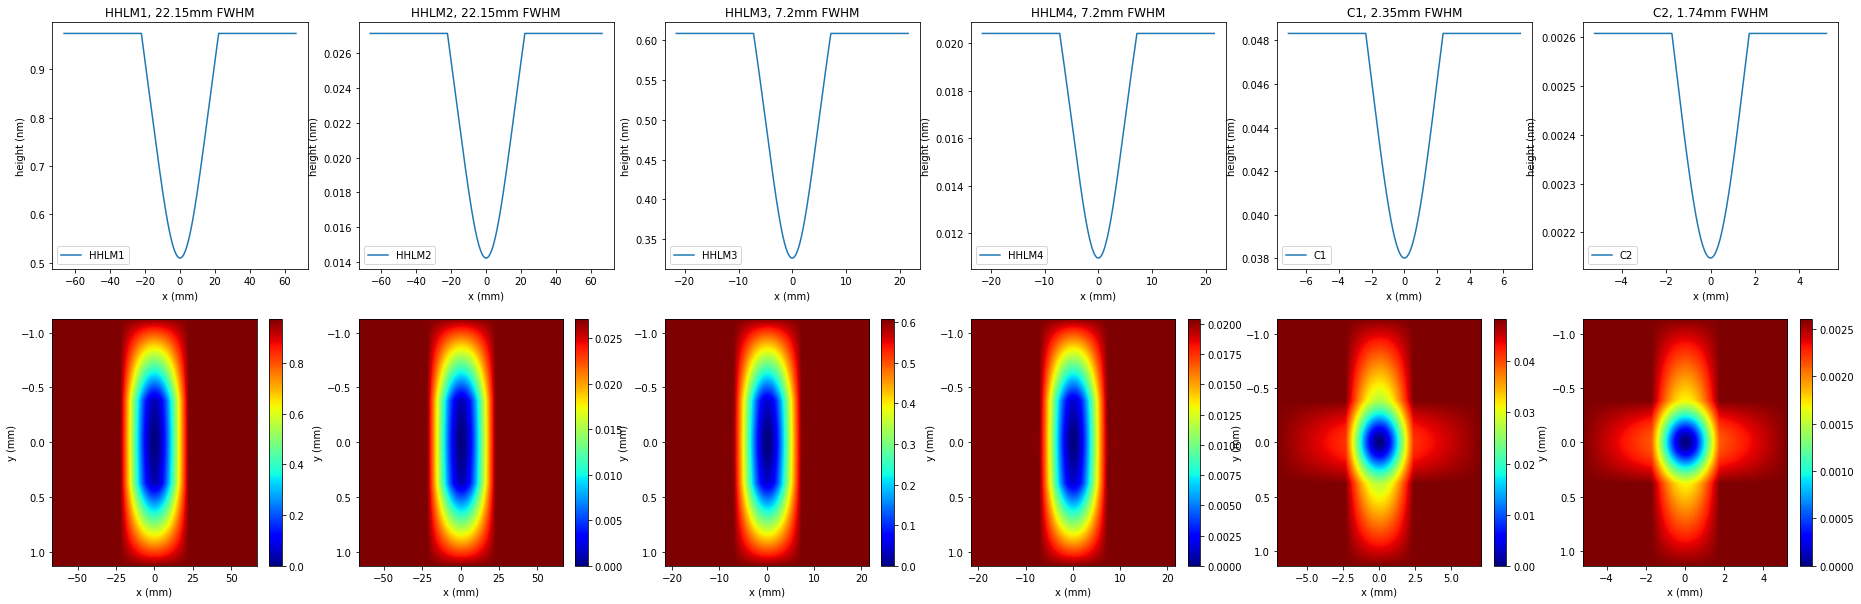

In [7]:
# crystal_powers = np.array([30.8657, 0.2617, 2.9498, 0.1011, 0.1322, 0.0895])*0.5    # crytal power for 2DCM-111-220 symmetric
crystal_powers = np.array([23.1779, 0.6461, 7.3485, 0.2464, 2.3548, 0.1163])*0.1    # crytal power for 2DCM-111-220 asymmetric

crystal_powers *= np.array([1,0,0,0,0,0])

# directories
dir_profile = '../DXS_Xtals_FEA4WFS/{}/'.format(HHLM_type)

if_pad = 1

# holders
shapeErrors = [None for i in range(n_crys)]
x_mirs      = [None for i in range(n_crys)]
y_mirs      = [None for i in range(n_crys)]

if HHLM_type == 'Zigzag':
    crystal_profile_powers = np.array([
        [73.15, 16.53, 0.029, 0.027, 0.026, 0.03],
        [73.15, 16.79, 0.015, 0.015, 0.014, 0.013],
        [4.51, 50.1, 1.78, 1.69, 1.61, 1.88]
    ])
elif HHLM_type == '2DCM':
    crystal_profile_powers = np.array([
        [73.15, 0.027, 16.53, 0.029, 0.026, 0.03],
        [73.15, 0.015, 16.79, 0.015, 0.014, 0.013],
        [4.51, 1.69, 50.1, 1.78, 1.61, 1.88]
    ])

# choose shapeError profiles with the closest power
ratio_power = crystal_profile_powers/np.stack([crystal_powers for i in range(3)])
ratio_power[ratio_power<1] = 1/(ratio_power[ratio_power<1])
options = ratio_power.argmin(axis=0)+1

# load
for i, crystal in enumerate(crystals):
    if crystal_powers[i] == 0: continue
    # load profiles from file
    dy, xx, zz = load_crystal_data(dir_profile, crystal, options[i])
    # proportionality constant due to power and crystal dimension
    height_factor1 = crystal_powers[i] / crystal_profile_powers[options[i]-1, i]    
    height_factor2 = (l_crystal[i]*1e3/(xx.max()-xx.min()))*(w_crystal[i]*1e3/(zz.max()-zz.min()))
    shapeErrors[i] = dy*1e6 * height_factor1 / height_factor2    # [nm]
    nx, ny = shapeErrors[i].shape; end_val = shapeErrors[i].max()
    if if_pad == 1:
        # stretch in both directions
        shapeErrors[i] = np.pad(shapeErrors[i],
                                pad_width=((nx,nx),(ny,ny)), mode='linear_ramp',
                                end_values = ((end_val,end_val),(end_val,end_val)))
        # modify dimensions for the new profile
        l_crystal[i] *= 3; w_crystal[i] *= 3
        # new crytal axis
        x_mirs[i] = np.linspace(-l_crystal[i]/2, l_crystal[i]/2, ny*3)
        y_mirs[i] = np.linspace(-w_crystal[i]/2, w_crystal[i]/2, nx*3)
    else:
        x_mirs[i] = np.linspace(-l_crystal[i]/2, l_crystal[i]/2, ny)
        y_mirs[i] = np.linspace(-w_crystal[i]/2, w_crystal[i]/2, nx)


# plot
n_subplot = np.sum(crystal_powers!=0)
plt.figure(figsize=(n_subplot*5+2, 10))
for i in range(n_crys):
    if crystal_powers[i] == 0: continue
    plt.subplot(2, n_subplot, int(i+1))
    plt.plot(x_mirs[i]*1e3, shapeErrors[i][1024,:], label=crystals[i])
    plt.legend(); plt.xlabel('x (mm)'); plt.ylabel('height (nm)')
    if if_pad == 1:
        plt.title('{}, {}mm FWHM'.format(crystals[i], round(l_crystal[i]/2*1e3/3,2)))
    else:
        plt.title('{}, {}mm FWHM'.format(crystals[i], round(l_crystal[i]/2*1e3,2)))
    plt.subplot(2, n_subplot, int(i+n_subplot+1))
    plt.imshow(shapeErrors[i], cmap='jet',
              extent = [x_mirs[i].min()*1e3, x_mirs[i].max()*1e3, y_mirs[i].max()*1e3, y_mirs[i].min()*1e3])
    plt.colorbar(); plt.xlabel('x (mm)'); plt.ylabel('y (mm)'); plt.axis('tight')

# Phase plate calculation

### 1. simulate the output of a monochromatic incident pulse w/ & w/o shapeError

In [8]:
%%capture capt
##### w/o shapeError
mono_devices_p, mono_beamline_p = define_beamline_normal(E0,
                               m1_p=m1_p, m1_q=m1_q, m2_p=m2_p,
                               HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=[None for i in range(6)],
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

beam_params['photonEnergy'] = E0
b1_p = beam.Beam(beam_params=beam_params)
b2_p = mono_beamline_p.propagate_beamline(b1_p)

##### w/ shapeError and corrected with mirror 2 bending
mono_devices_e, mono_beamline_e = define_beamline_normal(E0,
                               m1_p=m1_p, m1_q=m1_q, m2_p=m2_p,
                               HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

beam_params['photonEnergy'] = E0
b1_e = beam.Beam(beam_params=beam_params)
b2_e = mono_beamline_e.propagate_beamline(b1_e)

### 2. get phase info from the outputs and convert to phase plate thickness

Text(0, 0.5, 'y (mm)')

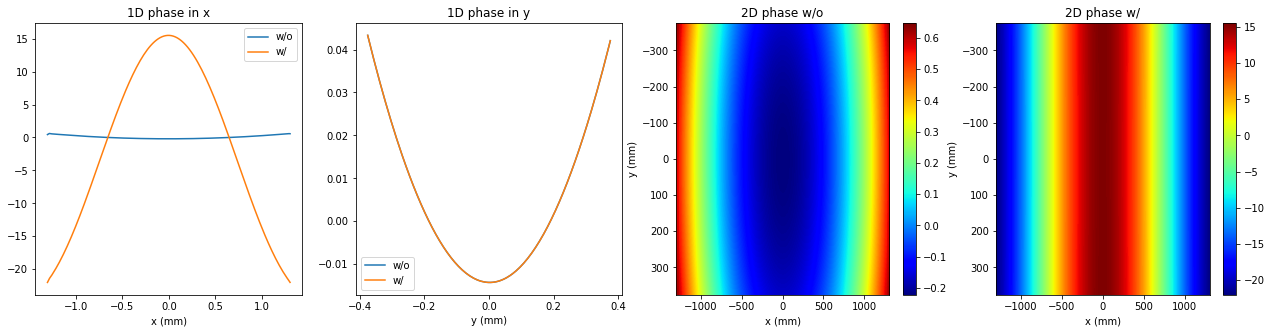

In [9]:
##### getting phase info
# get output image plane
ppm_p = mono_beamline_p.im_plate
ppm_e = mono_beamline_e.im_plate
x_plate = 2*ppm_p.get_x_width(); y_plate = 2*ppm_p.get_y_width()
# x_plate = 2*ppm_p.get_x().max(); y_plate = 2*ppm_p.get_y().max()

# crop roi based on beam width
index_x = np.where((ppm_p.x **2) < ((x_plate/2) ** 2))[0]
index_y = np.where((ppm_p.y **2) < ((y_plate/2) ** 2))[0]
axis_x = np.linspace(-x_plate/2, x_plate/2, index_x[-1] - index_x[0] + 1)*1e3
axis_y = np.linspace(-y_plate/2, y_plate/2, index_y[-1] - index_y[0] + 1)*1e3

# 1D phase info
phase_p_x = ppm_p.x_phase[index_x[0]:index_x[-1]+1]
phase_p_y = ppm_p.y_phase[index_y[0]:index_y[-1]+1]
phase_e_x = ppm_e.x_phase[index_x[0]:index_x[-1]+1]
phase_e_y = ppm_e.y_phase[index_y[0]:index_y[-1]+1]

# 2D phase info
phase_p_2d = np.unwrap(np.angle(ppm_p.complex_beam()[0]))[index_y[0]:index_y[-1]+1, index_x[0]:index_x[-1]+1]
phase_e_2d = np.unwrap(np.angle(ppm_e.complex_beam()[0]))[index_y[0]:index_y[-1]+1, index_x[0]:index_x[-1]+1]

# plots
plt.figure(figsize=(22,5))
plt.subplot(1,4,1)
plt.plot(axis_x, phase_p_x - np.median(phase_p_x), label='w/o')
plt.plot(axis_x, phase_e_x - np.median(phase_e_x), label='w/')
plt.legend()
plt.title('1D phase in x'); plt.xlabel('x (mm)')

plt.subplot(1,4,2)
plt.plot(axis_y, phase_p_y - np.median(phase_p_y), label='w/o')
plt.plot(axis_y, phase_e_y - np.median(phase_e_y), label='w/')
plt.legend()
plt.title('1D phase in y'); plt.xlabel('y (mm)')

plt.subplot(1,4,3)
plt.imshow(phase_p_2d-np.median(phase_p_2d), cmap='jet',
           extent = [axis_x.min()*1e3, axis_x.max()*1e3, axis_y.max()*1e3, axis_y.min()*1e3])
plt.colorbar()
plt.title('2D phase w/o'); plt.axis('tight')
plt.xlabel('x (mm)'); plt.ylabel('y (mm)')

plt.subplot(1,4,4)
plt.imshow(phase_e_2d-np.median(phase_e_2d), cmap='jet',
           extent = [axis_x.min()*1e3, axis_x.max()*1e3, axis_y.max()*1e3, axis_y.min()*1e3])
plt.colorbar()
plt.title('2D phase w/'); plt.axis('tight')
plt.xlabel('x (mm)'); plt.ylabel('y (mm)')

(-1.306071671562075, 1.306071671562075)

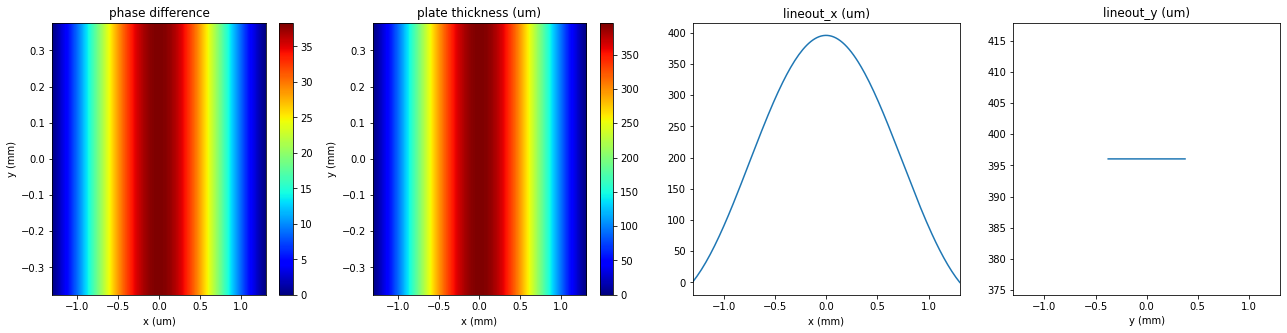

In [10]:
##### calculating phase difference and thickness
# phase advancement
phaseMap = phase_e_2d - phase_p_2d
phaseMap -= phaseMap.min()

# load material information from CXRO data
filename = os.path.join('../../LCLS/lcls_beamline_toolbox-beta/lcls_beamline_toolbox/xraybeamline2d/cxro_data/Be.csv')
cxro_data = np.genfromtxt(filename, delimiter=',')
energy = cxro_data[:, 0]; delta = cxro_data[:, 1]; beta = cxro_data[:, 2]
delta = np.interp(E0, energy, delta); beta = np.interp(E0, energy, beta)

# calculate thickness
plateThickness = phaseMap * b2_p.lambda0 / (delta*2*np.pi)

x_min = -ppm_p.get_x_width()*1e3; x_max = ppm_p.get_x_width()*1e3
y_min = -ppm_p.get_y_width()*1e3; y_max = ppm_p.get_y_width()*1e3

# plots
plt.figure(figsize=(22,5))
plt.subplot(1,4,1)
plt.imshow(phaseMap, cmap='jet',
           extent = [-wx4*1e3, wx4*1e3, wy4*1e3, -wy4*1e3])
plt.colorbar(); plt.axis('tight')
plt.title('phase difference')
plt.xlabel('x (um)'); plt.ylabel('y (mm)')
plt.xlim([x_min, x_max]); plt.ylim([y_min, y_max])

plt.subplot(1,4,2)
plt.imshow(plateThickness*1e6, cmap='jet',
           extent = [-wx4*1e3, wx4*1e3, wy4*1e3, -wy4*1e3])
plt.colorbar(); plt.axis('tight')
plt.title('plate thickness (um)')
plt.xlabel('x (mm)'); plt.ylabel('y (mm)')
plt.xlim([x_min, x_max]); plt.ylim([y_min, y_max])

plt.subplot(1,4,3)
plt.plot(axis_x, plateThickness[int(plateThickness.shape[0]/2)] * 1e6)
plt.xlabel('x (mm)'); plt.title('lineout_x (um)')
plt.xlim([x_min, x_max])

plt.subplot(1,4,4)
plt.plot(axis_y, plateThickness[:,int(plateThickness.shape[1]/2)] * 1e6)
plt.xlabel('y (mm)'); plt.title('lineout_y (um)')
plt.xlim([x_min, x_max])

# New class for PhasePlate optics

In [11]:
class PhasePlate:
    """
    Attributes
    ----------
    name: str
        Name of the device (e.g. CRL1)
    plateThickness: float
        Thickness profile of the phase plate. (meters)
    x_plate: float
        Phase plate size in x. (meters)
    y_plate: float
        Phase plate size in y. (meters)
    E0: float or None
        photon energy in eV for calculating the corresponding phase difference of a given thickness
    material: str
        Phase plate material. Currently only Be is implemented but may add CVD diamond in the future.
        Looks up downloaded data from CXRO.
    dx: float
        Phase plate de-centering along beam's x-axis.
    dy: float
        Phase plate de-centering along beam's y-axis.
    z: float
        z location of phase plate along beamline.
    energy: (N,) ndarray
        List of photon energies from CXRO file (eV).
    delta: (N,) ndarray
        Real part of index of refraction. n = 1 - delta + 1j * beta
    beta: (N,) ndarray
        Imaginary part of index of refraction. n = 1 - delta + 1j * beta
    """
    
    def __init__(self, name, plateThickness=None, x_plate=None, y_plate=None, E0=None, material='Be', z=0, dx=0, dy=0):
        """
        Method to create a PhasePlate object.
        :param name: str
            Name of the device (e.g. Phase1)
        :param plateThickness: float
            Thickness profile of the phase plate. (meters)
        :x_plate: float
            Phase plate size in x. (meters)
        :y_plate: float
            Phase plate size in y. (meters)
        :param E0: float
            photon energy for calculating radius of curvature for a given focal length (eV)
        :param material: str
            Lens material. Currently only Be is implemented but may add CVD diamond in the future.
            Looks up downloaded data from CXRO.
        :param z: float
            z location of lenses along beamline.
        :param dx, dy: float
            PhasePlate de-centering along beam's x,y-axis.
        :param orientation: int
            Whether or not this is a horizontal or vertical lens (0 for horizontal, 1 for vertical).
        """
        
        # set some attributes
        self.name = name
        self.plateThickness = plateThickness
        self.x_plate = x_plate
        self.y_plate = y_plate
        self.E0 = E0
        self.material = material
        self.dx = dx
        self.dy = dy
        self.z = z
        self.global_x = 0
        self.global_y = 0
        self.azimuth = 0
        self.elevation = 0
        self.xhat = None
        self.yhat = None
        self.zhat = None

        # get file name of CXRO data
        filename = os.path.join('../../LCLS/lcls_beamline_toolbox-beta/lcls_beamline_toolbox/xraybeamline2d/cxro_data/Be.csv')

        # load in CXRO data
        cxro_data = np.genfromtxt(filename, delimiter=',')
        self.energy = cxro_data[:, 0]
        self.delta = cxro_data[:, 1]
        self.beta = cxro_data[:, 2]

    def multiply(self, beam):
        """
        Method to propagate beam through PhasePlate
        :param beam: Beam
            Beam object to propagate through PhasePlate. Beam is modified by this method.
        :return: None
        """
        
        # get shape of phase plate thickness
        self.plate_shape = np.shape(self.plateThickness)
        Ms = self.plate_shape[0]; Ns = self.plate_shape[1]
        
        
        beamx = beam.x
        beamy = beam.y
        central_line_x = self.plateThickness[np.int(Ms/2)]
        central_line_y = self.plateThickness[:, np.int(Ns/2)]
        
        Ms = central_line_x.size; Ns = central_line_y.size
        xs = np.linspace(-Ms/2, Ms/2 -1, Ms) * self.x_plate/Ms    # phase plate x coordinate
        ys = np.linspace(-Ns/2, Ns/2 -1, Ns) * self.y_plate/Ns    # phase plate y coordinate
        
        # interpolation onto beam coordinates
        thickness_x = np.interp(beamx - self.dx, xs, central_line_x, left=0, right=0)
        thickness_y = np.interp(beamy - self.dy, ys, central_line_y, left=0, right=0)

        # interpolate to find index of refraction at beam's energy
        delta = np.interp(beam.photonEnergy, self.energy, self.delta)
        beta = np.interp(beam.photonEnergy, self.energy, self.beta)
        phase_x = -beam.k0 * delta * thickness_x
        phase_y = -beam.k0 * delta * thickness_y
        
        # transmission based on beta and thickness profile
        mask_x = (((beamx - self.dx) ** 2) < (self.x_plate / 2) ** 2).astype(float)
        mask_y = (((beamy - self.dy) ** 2) < (self.y_plate / 2) ** 2).astype(float)
        transmission_x = np.exp(-beam.k0 * beta * thickness_x) * np.exp(1j * phase_x) * mask_x
        transmission_y = np.exp(-beam.k0 * beta * thickness_y) * np.exp(1j * phase_y) * mask_y
        
        beam.wavex *= transmission_x
        beam.wavey *= transmission_y

    def propagate(self, beam):
        """
        Method to propagate beam through PhasePlate. Calls multiply.
        :param beam: Beam
            Beam object to propagate through PhasePlate. Beam is modified by this method.
        :return: None
        """
        self.multiply(beam)

# Beam profile simulation with the new PhasePlate optics

### new beamline function

In [12]:
def define_beamline_phase(
    E0, m1_p=185.0, m1_q=-25.6, m2_p=140.0, m2_q=None,
    HHLM_type='2DCM', HHLM_offset=20e-3, pair_distance=200e-3,
    slit_width=3e-6, f1=10.0, f2=10.0,
    hkl1 = [1,1,1], alphaAsym1 = 0.0,
    hkl2 = [2,2,0], alphaAsym2 = 0.0,
    hkl3 = [5,5,5], alphaAsym3 = 15.0,
    shapeErrors=[None for i in range(6)],
    l_crystal=[1e-1 for i in range(6)],
    w_crystal = [5e-3 for i in range(6)]):
    
    z_s = 650

    # viewing point - upstream of monochromator
    im_input = optics.PPM('im_input', z=184+z_s, FOV=FOV1, N=N1)
    
    Telescope_devices = define_Telescope(E0, m1_p=m1_p, m1_q=m1_q, m2_p=m2_p, m2_q=m2_q)
    
    if HHLM_type == '2DCM':
        HHLM_devices = define_HHLM_2DCM(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    elif HHLM_type == 'Zigzag':
        HHLM_devices = define_HHLM_Zigzag(E0,
                                    HHLM_offset=HHLM_offset,
                                    pair_distance=pair_distance,
                                    hkl1=hkl1, alphaAsym1=alphaAsym1,
                                    hkl2=hkl2, alphaAsym2=alphaAsym2,
                                    shapeErrors=shapeErrors,
                                    l_crystal=l_crystal,
                                    w_crystal = w_crystal)
    
    Phase1 = PhasePlate('Phase1', plateThickness=plateThickness, x_plate=x_plate, y_plate=y_plate, E0=E0, z=HHLM_devices[-1].z + 1e-3)
    im_plate = optics.PPM('im_plate', FOV=FOV2, N=N2, z=Phase1.z+1e-3)
    
    HRM_devices = define_HRM(E0, f1=f1, f2=f2, slit_width=slit_width,
                            hkl=hkl3, alphaAsym=alphaAsym3,
                            shapeErrors=shapeErrors,
                            l_crystal=l_crystal,
                            w_crystal=w_crystal)
    
    im_output = optics.PPM('im_output', FOV=FOV1,N=N1,z=HRM_devices[-1].z+1e-3)

    all_devices = [im_input] + Telescope_devices + HHLM_devices + [Phase1, im_plate] + HRM_devices + [im_output]
    
    mono_beamline = beamline.Beamline(all_devices, ordered=True)
    return all_devices, mono_beamline

### simulate the output with PhasePlate implemented

In [13]:
%%capture capt
mono_devices_c, mono_beamline_c = define_beamline_phase(E0,
                               m1_p=m1_p, m1_q=m1_q, m2_p=m2_p,
                               HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

beam_params['photonEnergy'] = E0
b1_c = beam.Beam(beam_params=beam_params)
b2_c = mono_beamline_c.propagate_beamline(b1_c)

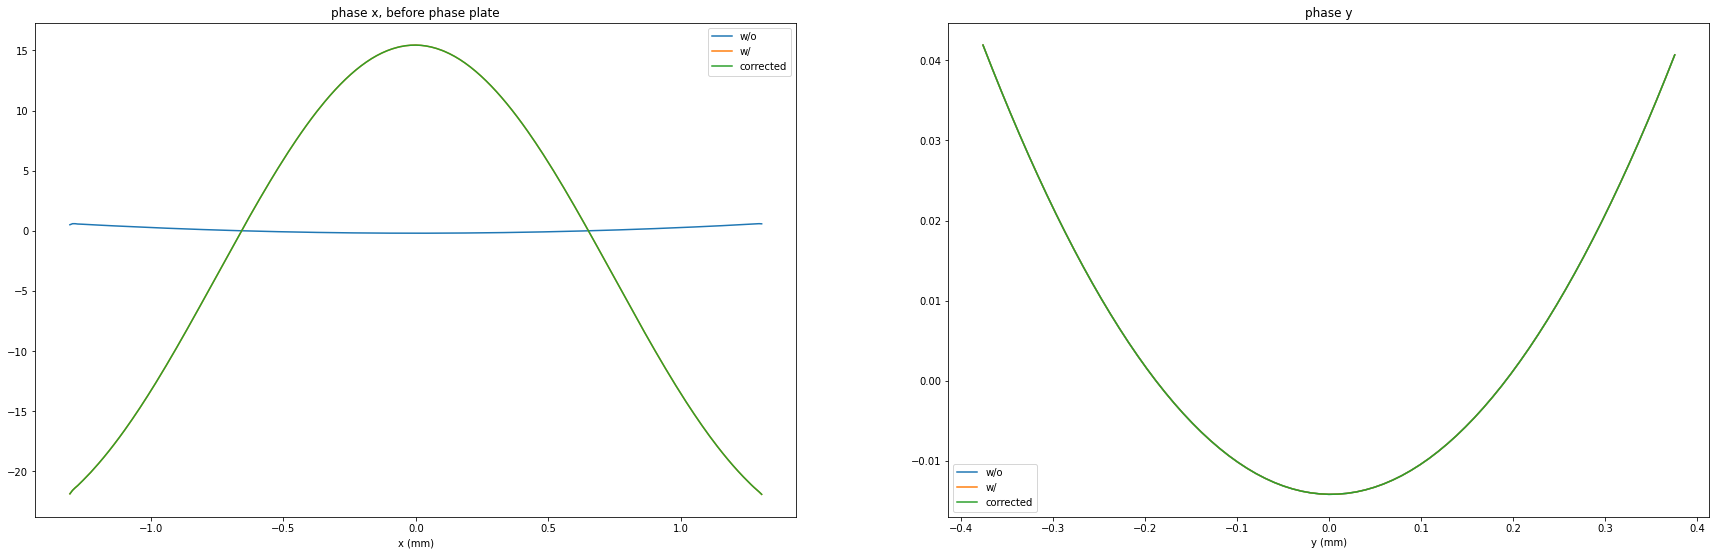

In [14]:
ppm_p = mono_beamline_p.im_after_HHLM4
ppm_e = mono_beamline_e.im_after_HHLM4
ppm_c = mono_beamline_c.im_after_HHLM4
x_range = ppm_p.get_x_width(); y_range = ppm_p.get_y_width()
image_name = 'before phase plate'

plot_phase_comparison(ppm_p, ppm_e, ppm_c, x_range, y_range, image_name=image_name)

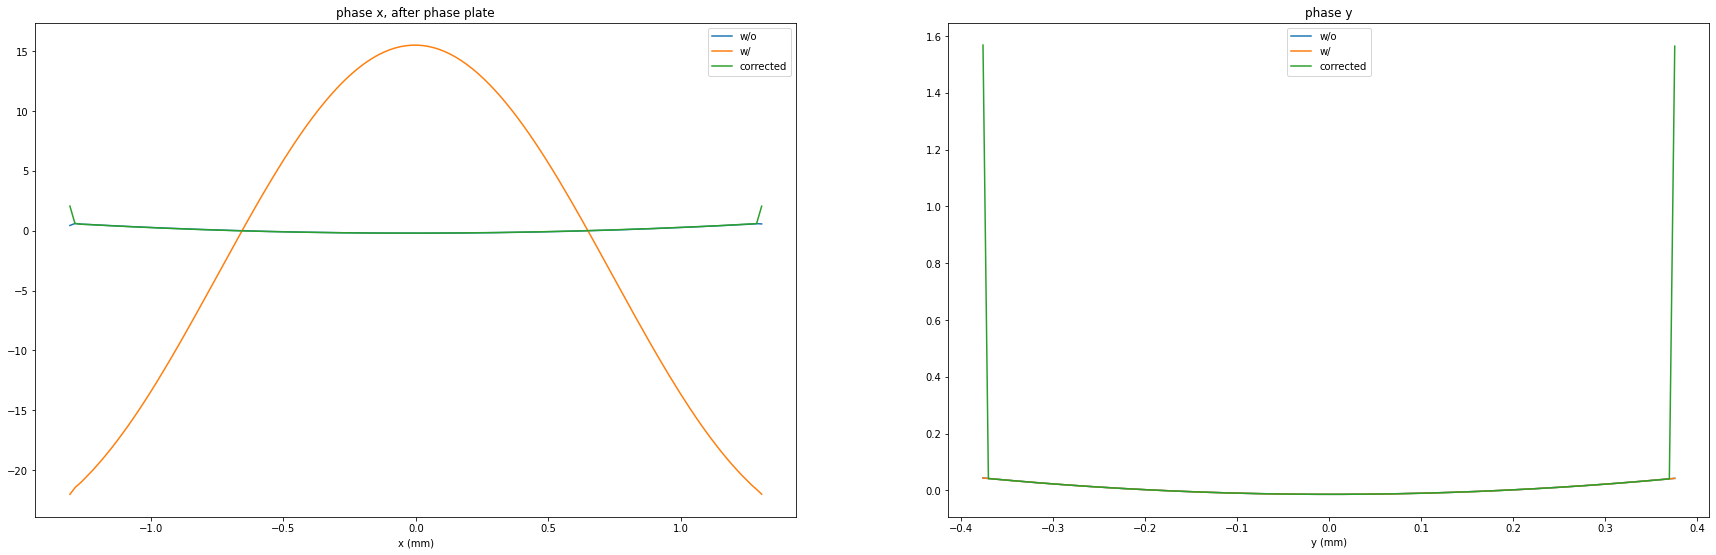

In [15]:
ppm_p = mono_beamline_p.im_plate
ppm_e = mono_beamline_e.im_plate
ppm_c = mono_beamline_c.im_plate
x_range = ppm_p.get_x_width(); y_range = ppm_p.get_y_width()
image_name = 'after phase plate'

plot_phase_comparison(ppm_p, ppm_e, ppm_c, x_range, y_range, image_name=image_name)

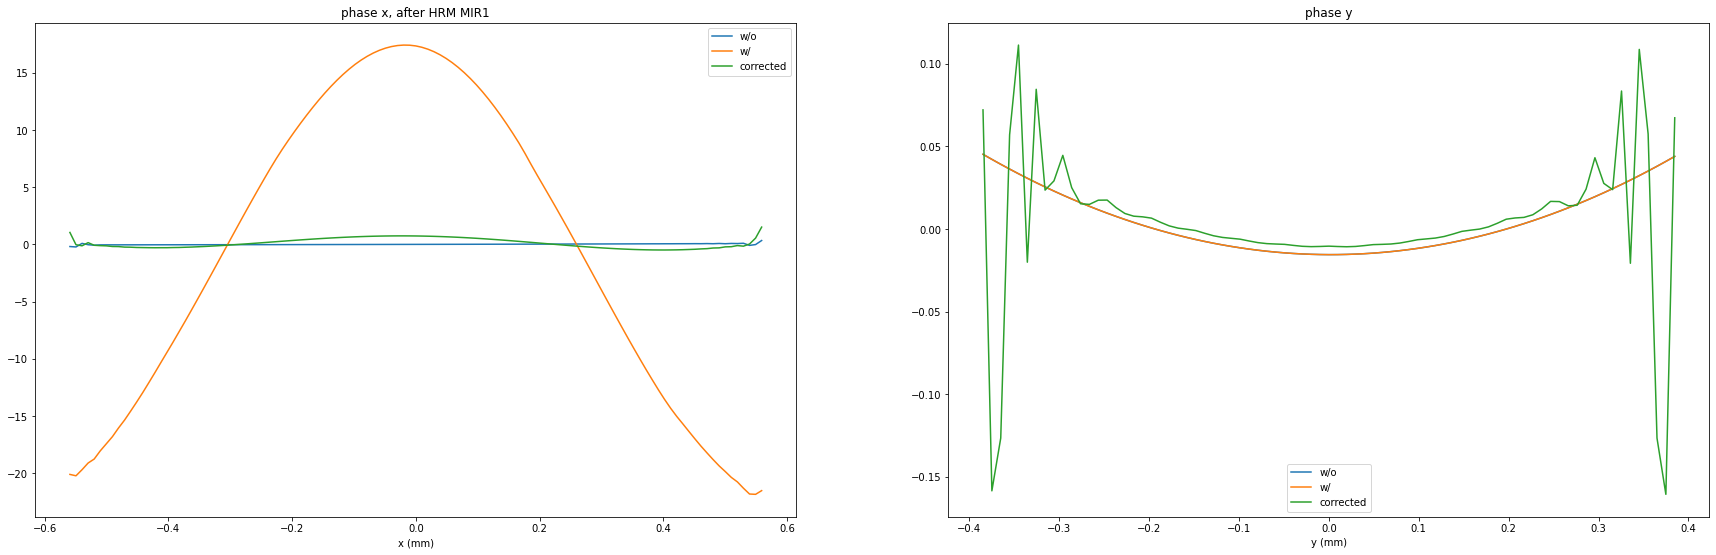

In [16]:
ppm_p = mono_beamline_p.im_after_MIR1
ppm_e = mono_beamline_e.im_after_MIR1
ppm_c = mono_beamline_c.im_after_MIR1
x_range = ppm_p.get_x_width(); y_range = ppm_p.get_y_width()
image_name = 'after HRM MIR1'

plot_phase_comparison(ppm_p, ppm_e, ppm_c, x_range, y_range, image_name=image_name)

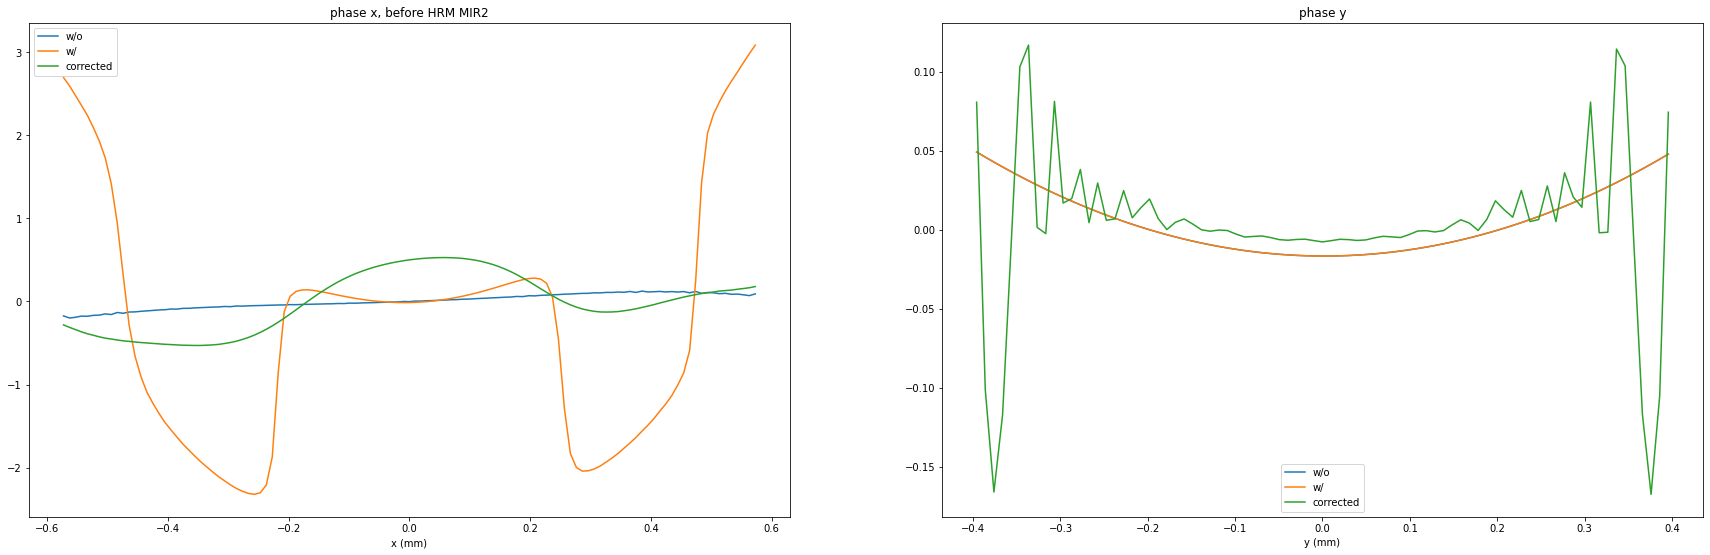

In [17]:
ppm_p = mono_beamline_p.im_before_MIR2
ppm_e = mono_beamline_e.im_before_MIR2
ppm_c = mono_beamline_c.im_before_MIR2
x_range = ppm_p.get_x_width(); y_range = ppm_p.get_y_width()
image_name = 'before HRM MIR2'

plot_phase_comparison(ppm_p, ppm_e, ppm_c, x_range, y_range, image_name=image_name)

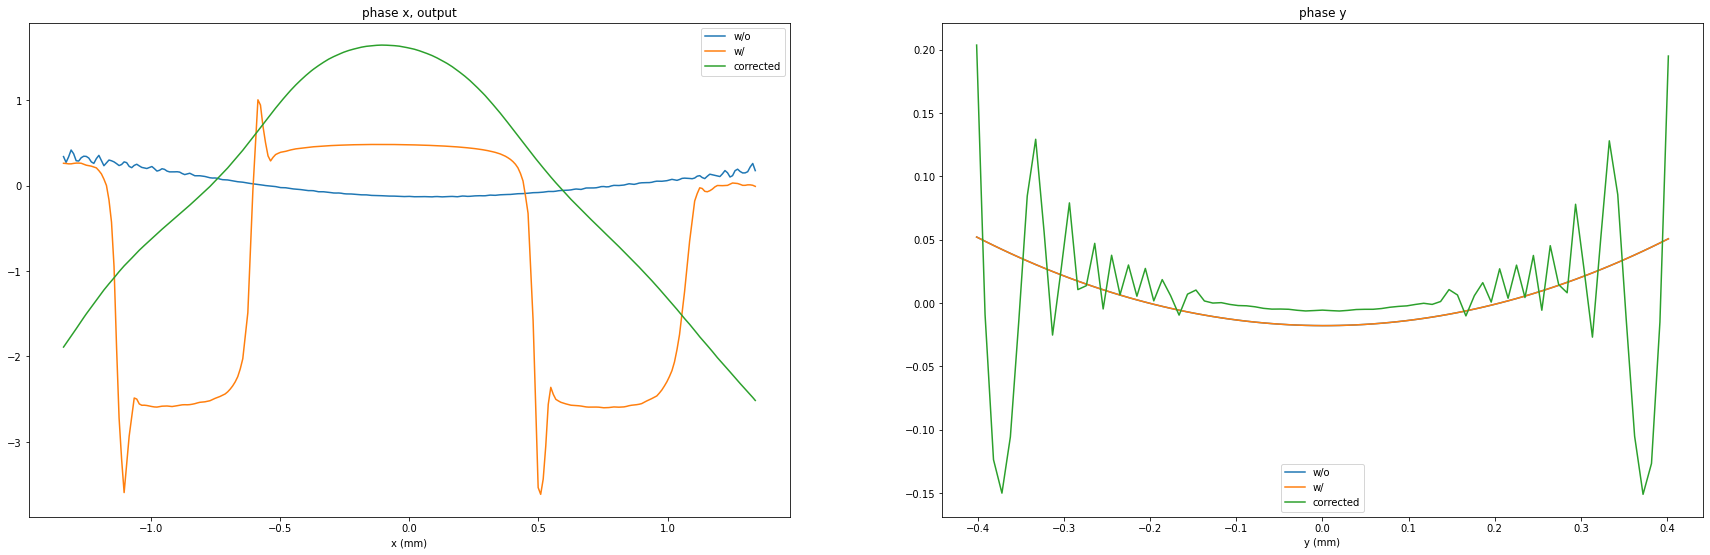

In [18]:
ppm_p = mono_beamline_p.im_output
ppm_e = mono_beamline_e.im_output
ppm_c = mono_beamline_c.im_output
x_range = ppm_p.get_x_width(); y_range = ppm_p.get_y_width()
image_name = 'output'

plot_phase_comparison(ppm_p, ppm_e, ppm_c, x_range, y_range, image_name=image_name)

### Adding time domain simulation and see what pulse looks like after being corrected...

In [19]:
%%capture capt
mono_devices_mp, mono_beamline_mp = define_beamline_phase(E0,
                               m1_p=m1_p, m1_q=m1_q, m2_p=m2_p1,
                               HHLM_type=HHLM_type,
                               HHLM_offset=HHLM_offset,
                               pair_distance=pair_distance,
                               slit_width=slit_width, f1=f1, f2=f2,
                               hkl1=hkl1, alphaAsym1=alphaAsym1,
                               hkl2=hkl2, alphaAsym2=alphaAsym2,
                               hkl3=hkl3, alphaAsym3=alphaAsym3,
                               shapeErrors=shapeErrors*6,
                               l_crystal=l_crystal,
                               w_crystal=w_crystal)

screen_names = ['im_input','im_after_T1','im_after_T2',
                'im_after_HHLM1','im_after_HHLM2','im_after_HHLM3','im_after_HHLM4',
                'im_after_C1','im_after_C2','im_before_MIR1','im_after_MIR1',
                'im_focus','im_before_MIR2','im_after_MIR2','im_after_C3','im_output'
               ]

beam_params['photonEnergy'] = E0
pulse = beam.Pulse(beam_params=beam_params, unit_spectrum=True, spectral_width=100e-3, N=100)
pulse.propagate(beamline=mono_beamline_mp,screen_names=screen_names)


im_focus failed


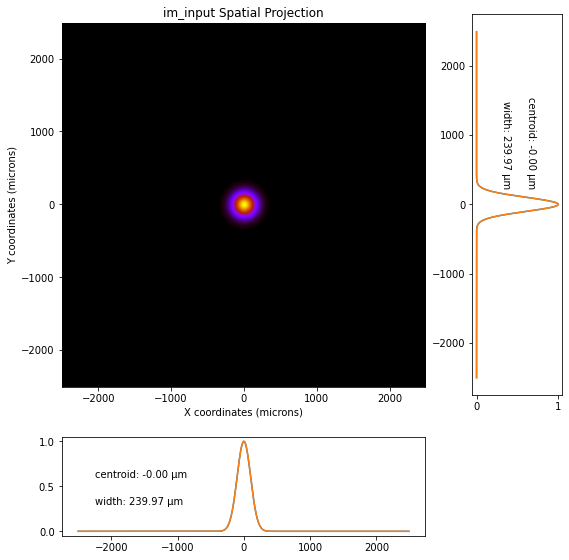

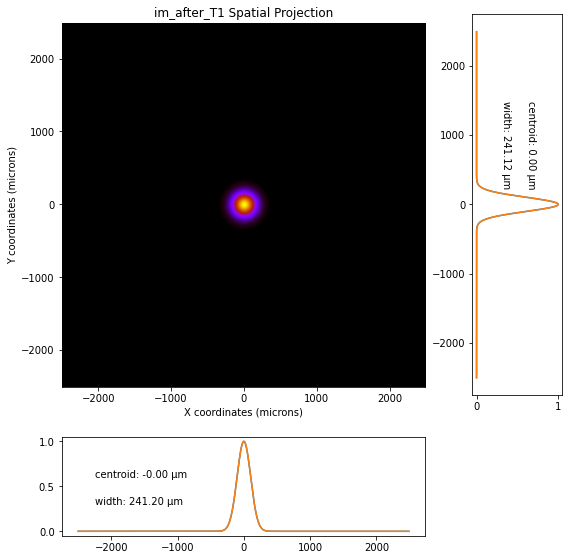

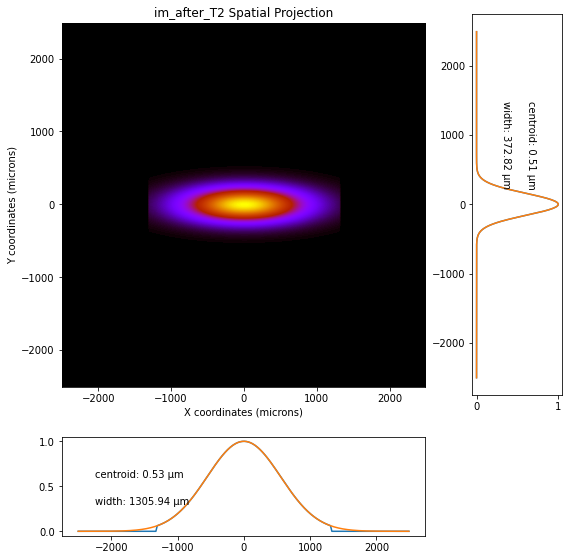

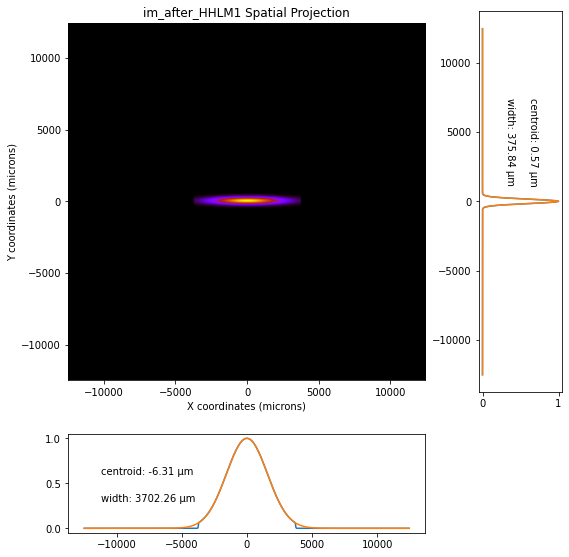

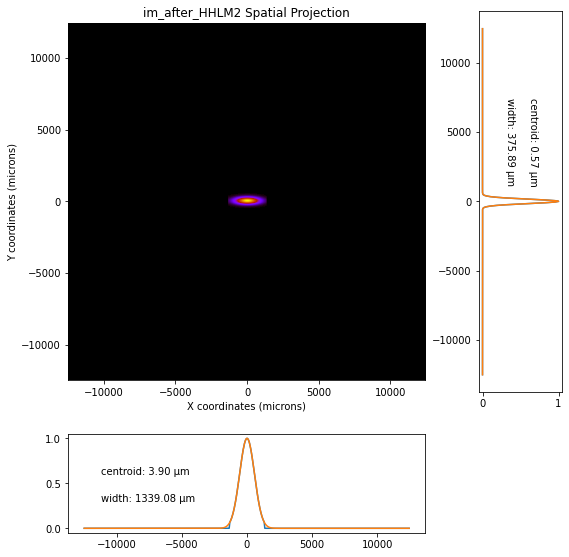

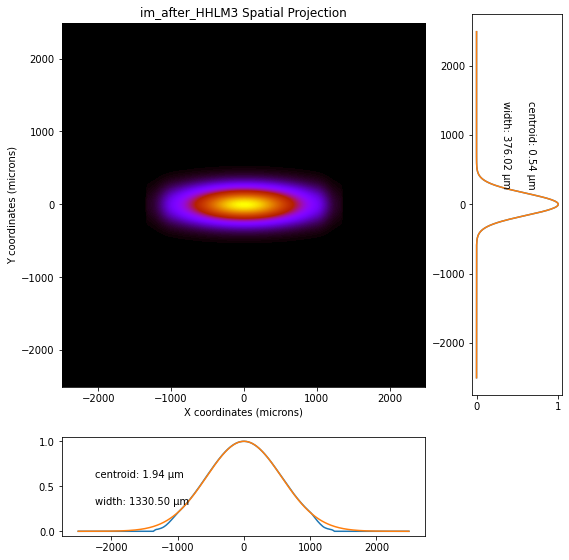

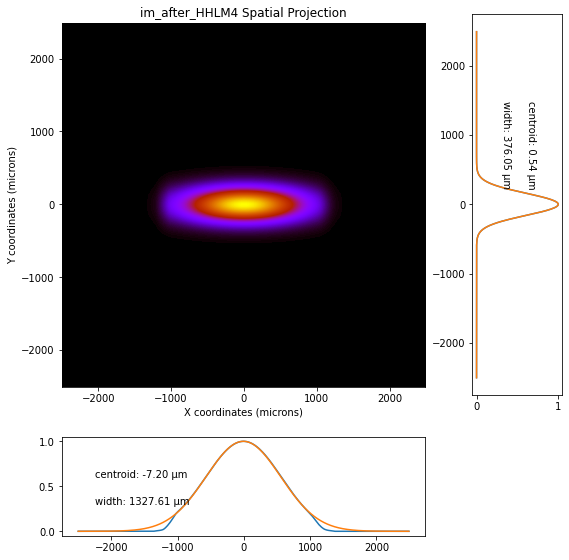

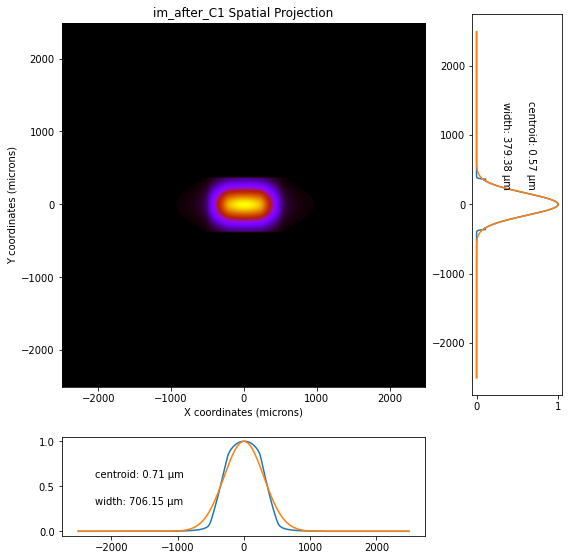

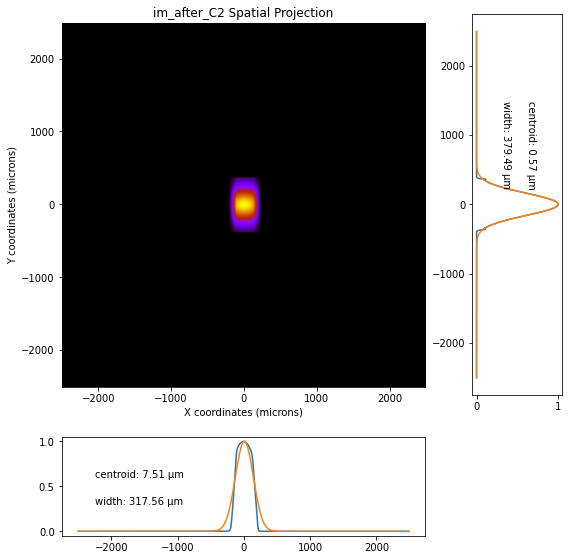

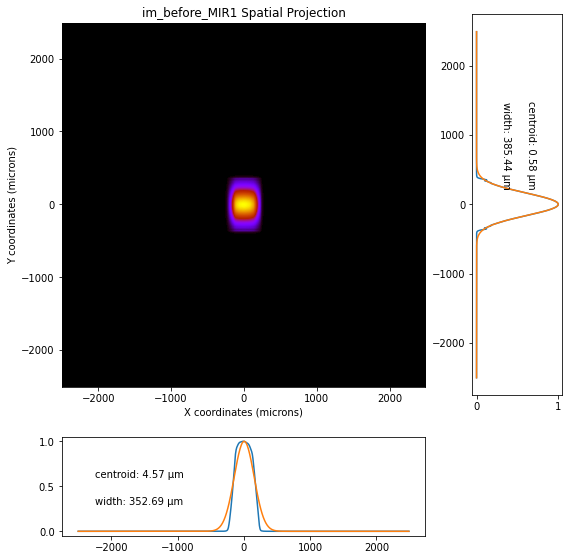

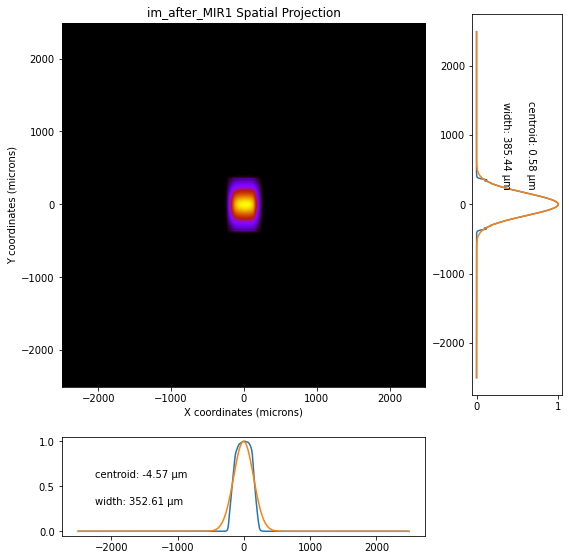

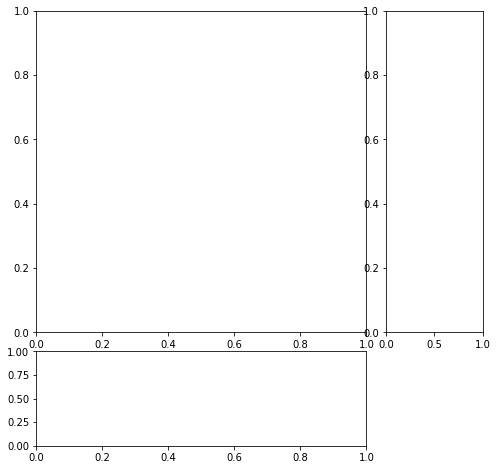

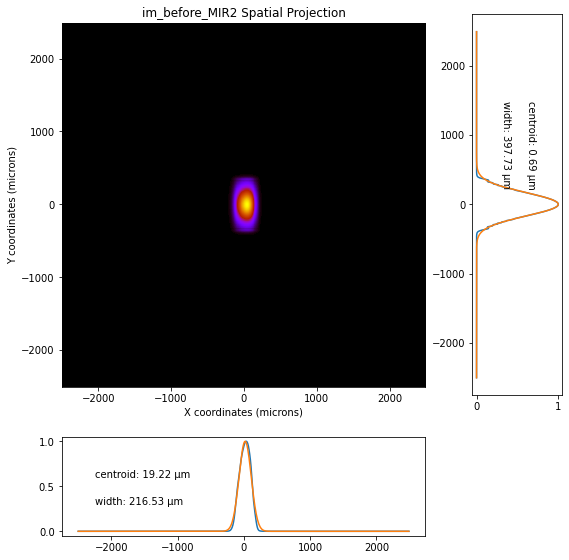

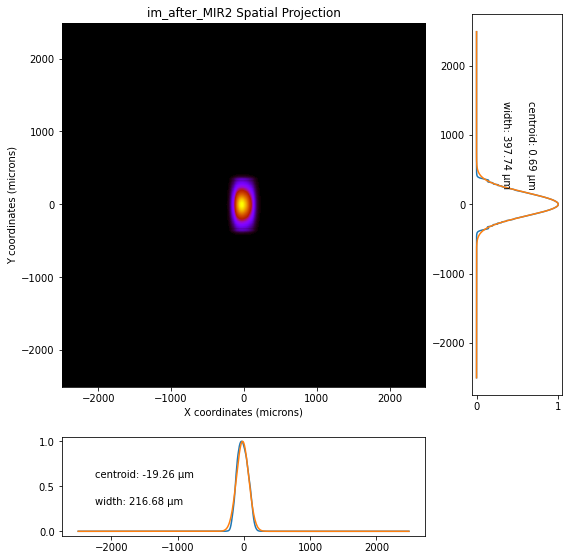

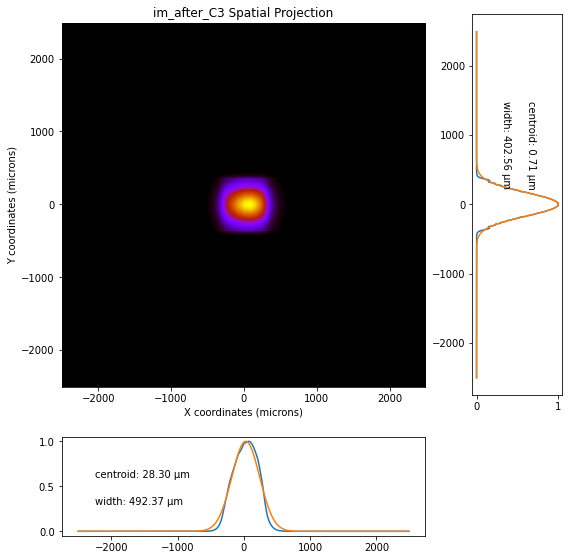

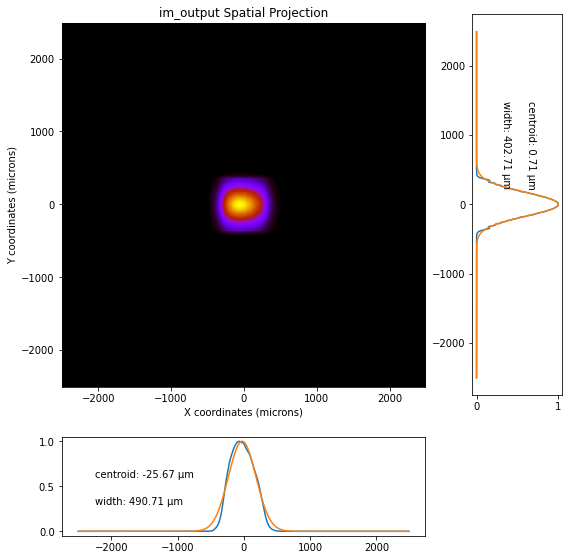

In [20]:
''' projection '''
dir_perfect = dir_plot

for i,screen_name in enumerate(pulse.screens):
    try:
        pulse.imshow_projection(screen_name)
        plt.savefig(dir_perfect+'projection_{}.{}.png'.format(i+1,screen_name))
    except:
        print(screen_name, 'failed')


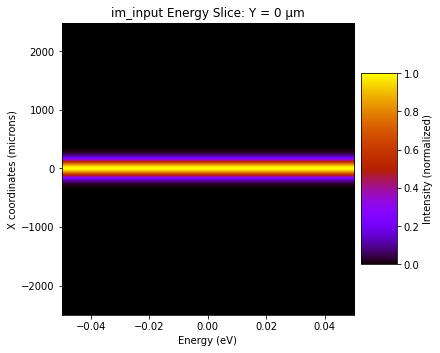

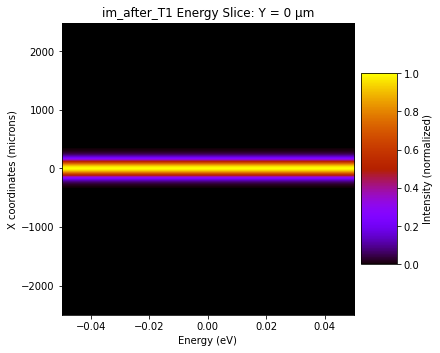

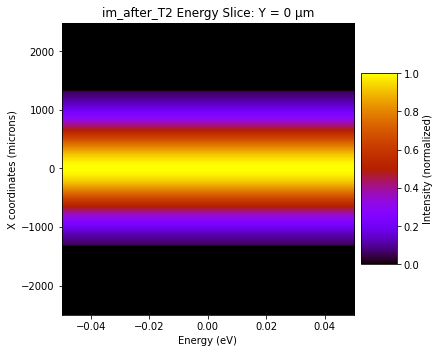

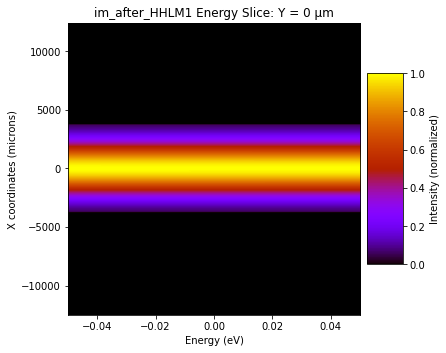

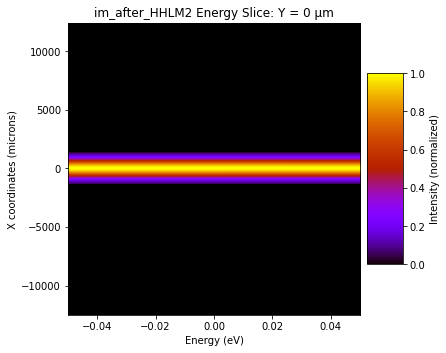

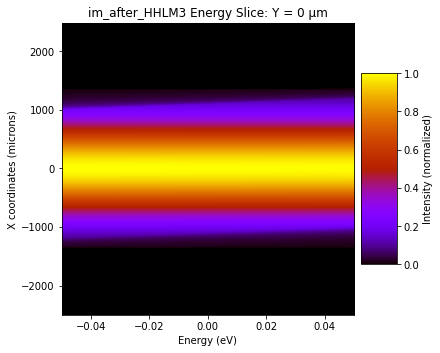

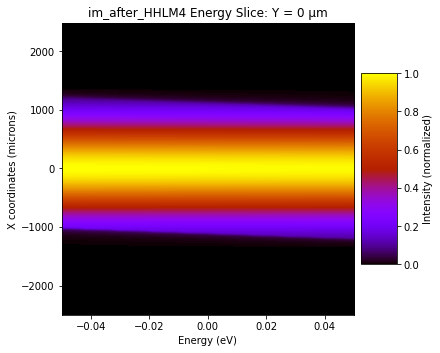

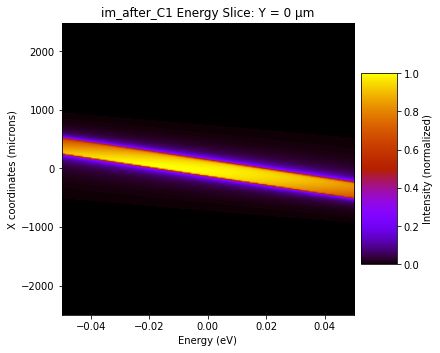

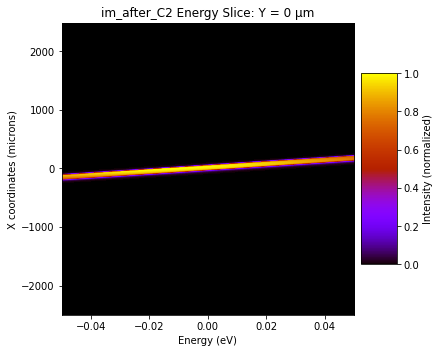

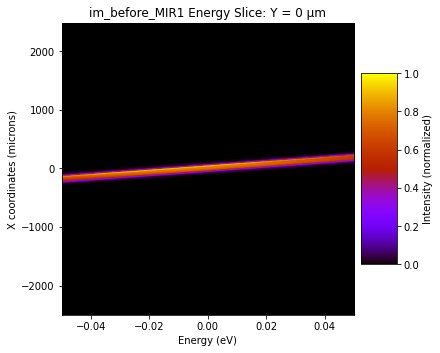

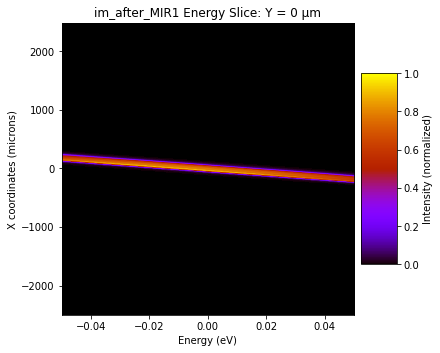

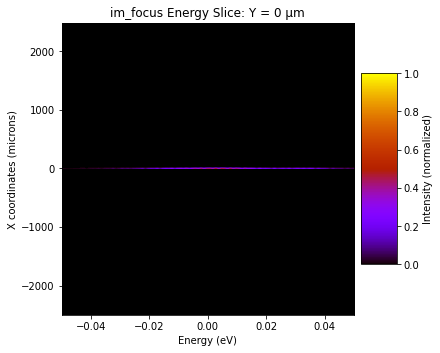

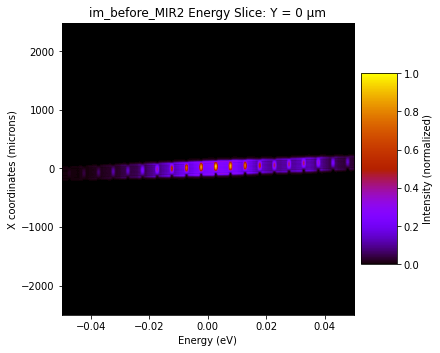

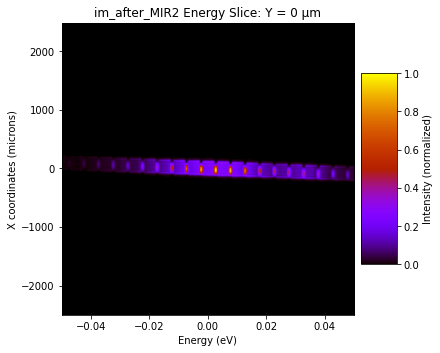

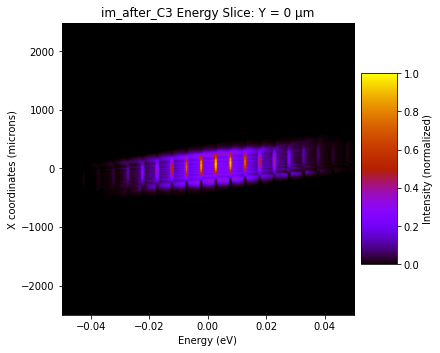

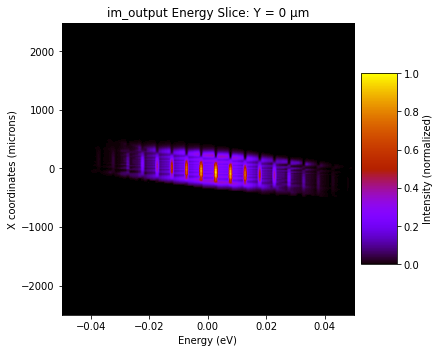

In [21]:
''' energy slices '''
for i,screen_name in enumerate(pulse.screens):
    try:
        pulse.imshow_energy_slice(screen_name)
        plt.savefig(dir_perfect+'spectrum_{}.{}.png'.format(i+1,screen_name))
    except:
        print(screen_name, 'failed')


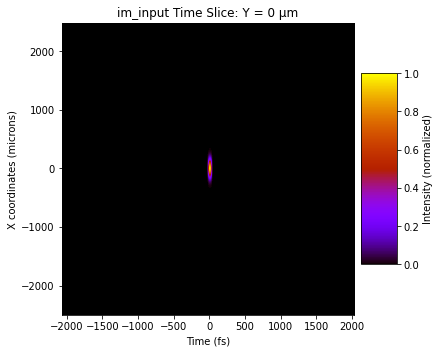

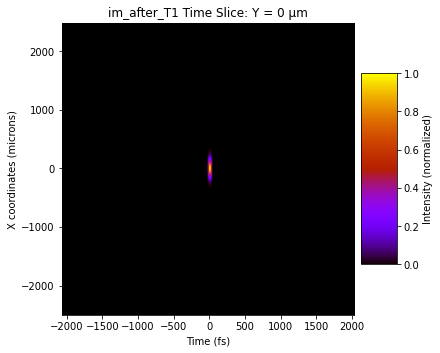

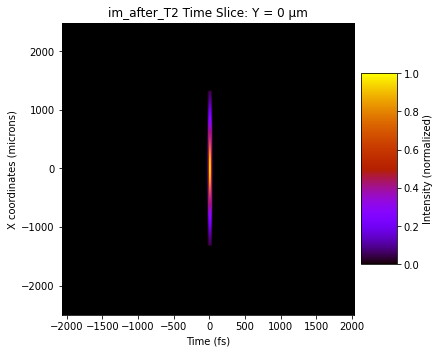

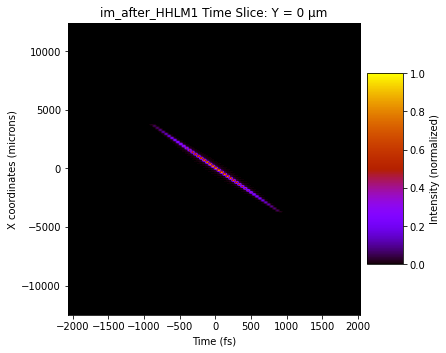

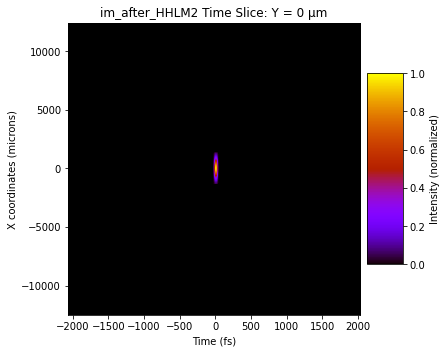

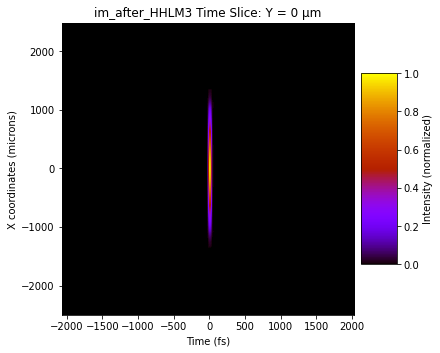

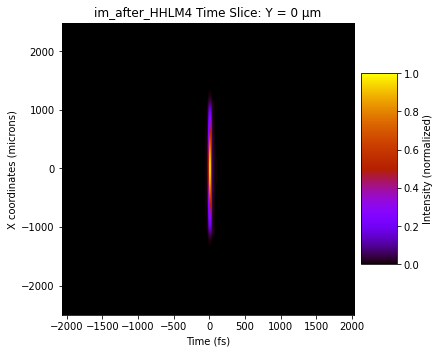

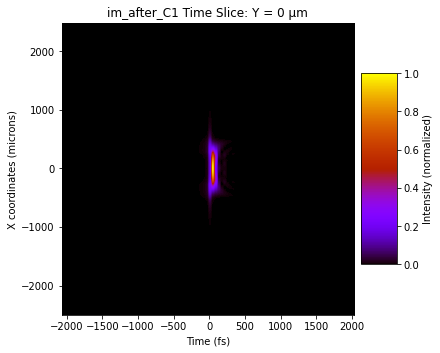

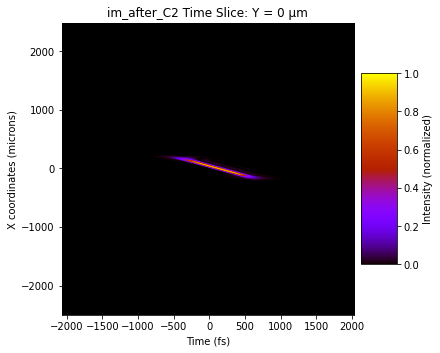

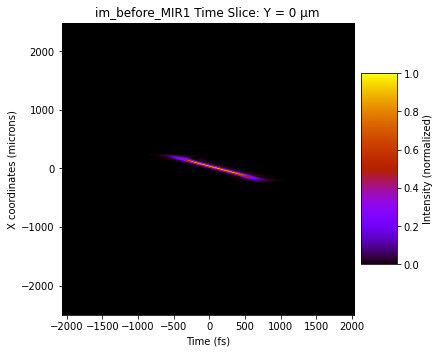

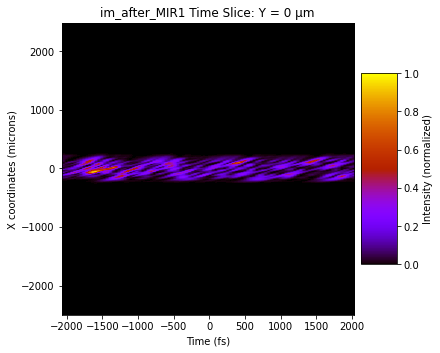

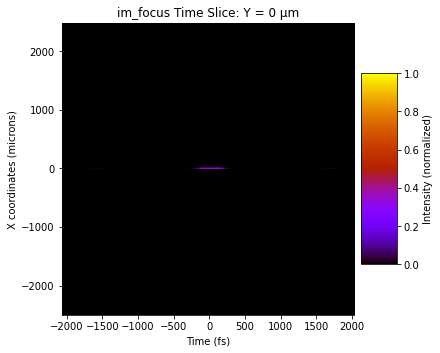

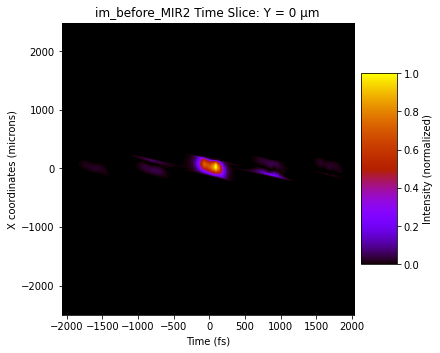

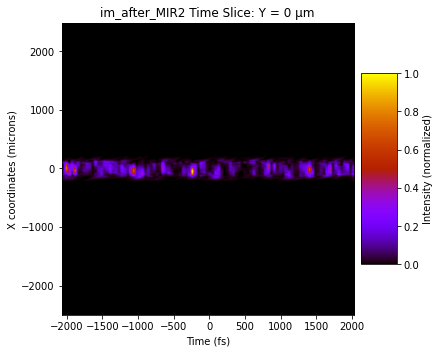

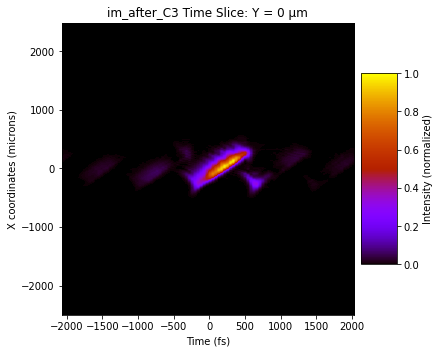

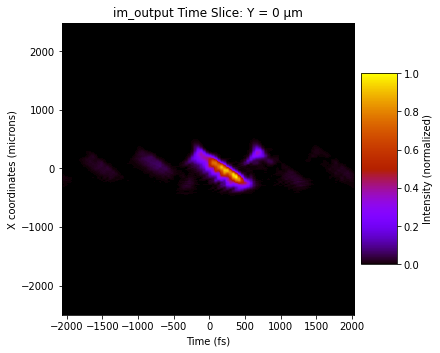

In [22]:
''' plot time slices '''
shift = 0
for i,screen_name in enumerate(pulse.screens):
    try:
        pulse.imshow_time_slice(screen_name, shift=shift)
        plt.savefig(dir_perfect+'tilt_{}.{}.png'.format(i+1,screen_name))
    except:
        print(screen_name, 'failed')

In [23]:
''' diagnostics '''
c, pulse_duration0 = pulse.pulse_duration('im_output')
pulse_tilt0 = pulse.pulsefront_tilt('im_output')
spatial_chirp0 = pulse.spatial_chirp('im_output')
energy_bandwidth0 = pulse.pulse_bandwidth('im_output')
throughput0 = pulse.throughput('im_input','im_output')
print('duration {}fs'.format(pulse_duration0))
print('tilt {}fs/um'.format(pulse_tilt0))
print('spatial chirp {}meV/um'.format(spatial_chirp0*1e3))
print('bandwidth {}meV'.format(energy_bandwidth0*1e3))
print('throughput {}%'.format(throughput0*1e2))


duration 242fs
tilt -1.1283310263809432fs/um
spatial chirp -0.021703064970229755meV/um
bandwidth 11.576348426398859meV
throughput 6.24884288294381%


In [24]:
import winsound
winsound.Beep(1500, 3000)